Importing the libraries to perform the classification

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import seaborn as sns


Loading the directory where the images are stored.

In [2]:
PATH = os.getcwd()+'/COVID-19_Radiography_Dataset'


In [3]:
os.listdir(PATH)


['.DS_Store', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']

Creating our dataset for the analysis purpose

In [4]:
# Image generator for training (includes data augmentation)
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,  # Set each sample mean to 0.
    # Divide each input by its standard deviation]
    samplewise_std_normalization=True,
    zoom_range=0.2,
    validation_split=0.2
)

# Image generator for Validation (didn't include augmentation)
imgValidGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,  # Set each sample mean to 0.
    samplewise_std_normalization=True,
    validation_split=0.2
)

# Image generator for testing (didn't include augmentation)
imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)
# Build for training
trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH,
    subset='training',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)
# Build for validation
validGeneratorBuild = imgValidGen.flow_from_directory(
    PATH,
    subset='validation',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)
# Build for testing
testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH,
    subset='validation',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)


Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


Exploratory Data Analysis

In [5]:
class_names = trainGeneratorBuild .class_indices
print(class_names)


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [6]:
classes = list(class_names.keys())
print(classes)


['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [7]:
images, labels = next(trainGeneratorBuild)
labels = np.argmax(labels, axis=1)
class_dict = trainGeneratorBuild.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

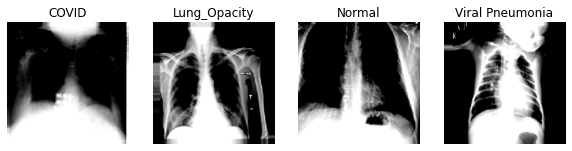

In [8]:
plt.figure(figsize=(10, 10))
for image in images:
    j = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1


In [9]:
all_items, dirs, files = next(os.walk(PATH))


In [10]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images = len(os.listdir(os.path.join(PATH, dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs, 'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)


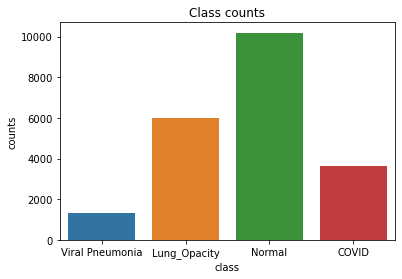

In [11]:
sns.barplot(x='class', y='counts', data=classes_df)
plt.title('Class counts')
plt.show()


Creating the EfficentNetB6 model

In [12]:
pretrained_base = tf.keras.applications.efficientnet.EfficientNetB6(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224, 224, 3), pooling=None, classes=1000,
    classifier_activation='softmax'
)

# Freeze the pretrained base
pretrained_base.trainable = False


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-11-22 08:56:06.527060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-22 08:56:06.527799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
x = pretrained_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
out =Dense(4, activation='softmax')(x)


# Creating our model
model = Model(inputs=pretrained_base.input, outputs=out)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           patience=5,
                           restore_best_weights=True)


In [16]:
mc = ModelCheckpoint('EfficientNetB6.h5', monitor='val_loss',
                     mode='min', verbose=1, save_best_only=True)


In [17]:
history = model.fit(trainGeneratorBuild, batch_size=32, epochs=10,
                    validation_data=validGeneratorBuild, callbacks=[early_stop, mc], verbose=1)


2021-11-22 08:56:47.917274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-22 08:56:47.918490: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-11-22 08:56:51.414961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - ETA: 0s - loss: 1.1969 - accuracy: 0.4767

2021-11-22 09:07:13.366850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - 775s 1s/step - loss: 1.1969 - accuracy: 0.4767 - val_loss: 1.1875 - val_accuracy: 0.4816

Epoch 00001: val_loss improved from inf to 1.18749, saving model to EfficientNetB6.h5


/Users/aqdus/miniforge3/envs/mlp/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
530/530 [==============================] - 788s 1s/step - loss: 1.1852 - accuracy: 0.4811 - val_loss: 1.1848 - val_accuracy: 0.4816

Epoch 00002: val_loss improved from 1.18749 to 1.18480, saving model to EfficientNetB6.h5
Epoch 3/10
530/530 [==============================] - 920s 2s/step - loss: 1.1815 - accuracy: 0.4814 - val_loss: 1.1733 - val_accuracy: 0.4816

Epoch 00003: val_loss improved from 1.18480 to 1.17331, saving model to EfficientNetB6.h5
Epoch 4/10
530/530 [==============================] - 931s 2s/step - loss: 1.1794 - accuracy: 0.4815 - val_loss: 1.1760 - val_accuracy: 0.4816

Epoch 00004: val_loss did not improve from 1.17331
Epoch 5/10
530/530 [==============================] - 1081s 2s/step - loss: 1.1775 - accuracy: 0.4815 - val_loss: 1.1750 - val_accuracy: 0.4816

Epoch 00005: val_loss did not improve from 1.17331
Epoch 6/10
530/530 [==============================] - 940s 2s/step - loss: 1.1769 - accuracy: 0.4817 - val_loss: 1.1679 - val_accuracy: 0.481

In [18]:
print("Train score:", model.evaluate(trainGeneratorBuild))
print("Validation score:", model.evaluate(validGeneratorBuild))
n_epochs = len(history.history['loss'])


530/530 [==============================] - 690s 1s/step - loss: 1.1621 - accuracy: 0.4815
Train score: [1.1620882749557495, 0.4815449118614197]
133/133 [==============================] - 197s 1s/step - loss: 1.1624 - accuracy: 0.4816
Validation score: [1.162401556968689, 0.4815690219402313]


Plotting the curve

In [19]:
def plotLearningCurve(history, epochs):
  epochRange = range(1, epochs+1)
  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].plot(epochRange, history.history['accuracy'],
             'b', label='Training Accuracy')
  ax[0].plot(epochRange, history.history['val_accuracy'],
             'r', label='Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize=20)
  ax[0].set_ylabel('Accuracy', fontsize=20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange, history.history['loss'], 'b', label='Training Loss')
  ax[1].plot(epochRange, history.history['val_loss'],
             'r', label='Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize=20)
  ax[1].set_ylabel('Loss', fontsize=20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()


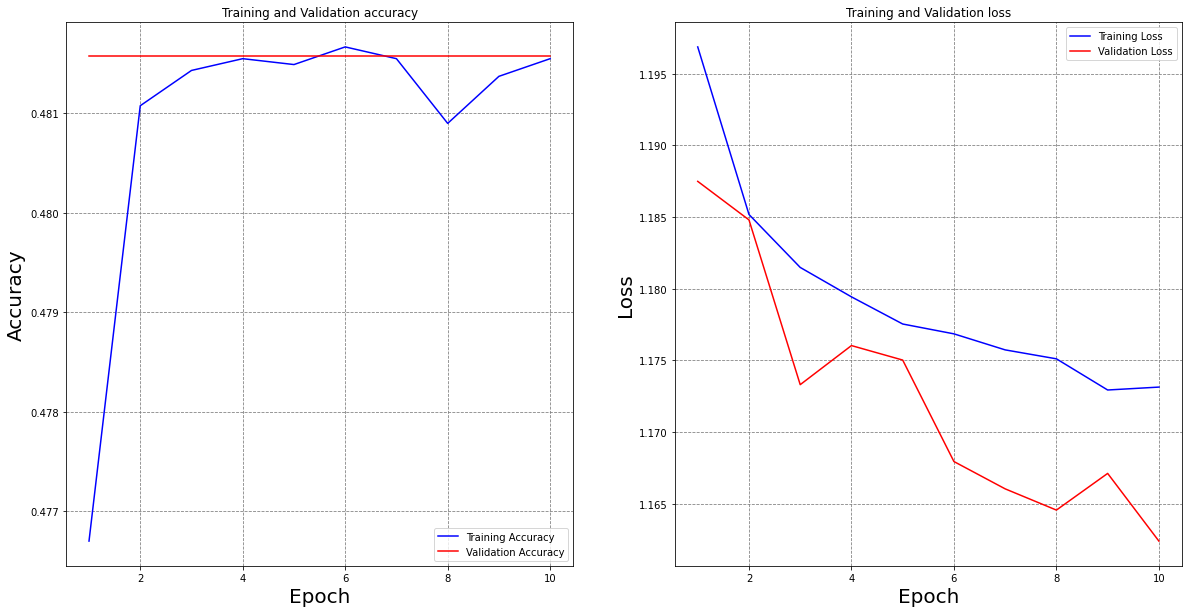

In [20]:
plotLearningCurve(history, n_epochs)


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [22]:
Y_pred = model.predict_generator(testGeneratorBuild)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(testGeneratorBuild.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
print(classification_report(testGeneratorBuild.classes,
      y_pred, target_names=target_names))


/Users/aqdus/miniforge3/envs/mlp/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-11-22 11:54:09.987690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion Matrix
[[   1  386  132  204]
 [   0  638  203  361]
 [   1 1099  358  580]
 [   0  141   51   77]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.50      0.00      0.00       723
   Lung_Opacity       0.28      0.53      0.37      1202
         Normal       0.48      0.18      0.26      2038
Viral Pneumonia       0.06      0.29      0.10       269

       accuracy                           0.25      4232
      macro avg       0.33      0.25      0.18      4232
   weighted avg       0.40      0.25      0.24      4232



Testing the model

In [23]:
from tensorflow.keras.preprocessing import image


def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224, 224, 3))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  return img


2021-11-22 11:56:40.220754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The given X-Ray image is of type = Lung_Opacity

The chances of image being Covid is : 17.32114404439926 percent

The chances of image being Lung_Opacity is : 31.432008743286133 percent

The chances of image being Normal is : 24.121737480163574 percent

The chances of image being Viral Pneumonia is : 27.12511420249939 percent


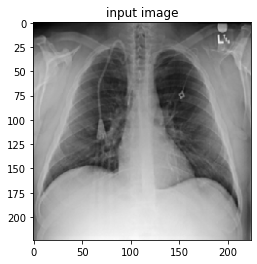

In [24]:
# path for that new image.
PATH = os.getcwd()+'/COVID-19_Radiography_Dataset/Normal/Normal-5.png'
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# you can add any image path
img = get_img_array(PATH)

res = class_names[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(
    f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(
    f"The chances of image being Lung_Opacity is : {model.predict(img)[0][1]*100} percent")
print()
print(
    f"The chances of image being Normal is : {model.predict(img)[0][2]*100} percent")
print()
print(
    f"The chances of image being Viral Pneumonia is : {model.predict(img)[0][3]*100} percent")


# to display the image
plt.imshow(img[0]/255, cmap="gray")
plt.title("input image")
plt.show()
